# MobileNetV3
## Con parametri uguali al primo tentativo ma meno epoche

Ci connettiamo alla cartella di drive che contiene il test-set ed il trainig-set, oltre ai modelli salvati

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Si estrae quello che sarà il trainig set

In [ ]:
!cp  /content/drive/MyDrive/trainingSetFull.zip /content/ #Copia il path
!unzip /content/trainingSetFull.zip -d /content/ #Unzippa il path

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/trainingSet/51/14014/407_20220310_0.jpg  
   creating: /content/trainingSet/51/14015/
  inflating: /content/trainingSet/51/14015/47_20220222_0.jpg  
   creating: /content/trainingSet/51/14016/
  inflating: /content/trainingSet/51/14016/47_20220222_0.jpg  
  inflating: /content/trainingSet/51/14016/47_20220222_1.jpg  
   creating: /content/trainingSet/51/14017/
  inflating: /content/trainingSet/51/14017/28_20210614_0.jpg  
  inflating: /content/trainingSet/51/14017/56_20211110_1.jpg  
   creating: /content/trainingSet/51/14018/
  inflating: /content/trainingSet/51/14018/1799_20220314_3.jpg  
  inflating: /content/trainingSet/51/14018/1799_20220314_4.jpg  
  inflating: /content/trainingSet/51/14018/407_20220310_0.jpg  
  inflating: /content/trainingSet/51/14018/407_20220310_1.jpg  
   creating: /content/trainingSet/51/14019/
  inflating: /content/trainingSet/51/14019/1799_20220314_1.jpg  
  inflating: /content/traini

In [2]:
!pip install tensorflow_addons #Installa Tensorflow Addons per python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 17.1 MB/s 


Viene eseguito l'import di tutte le libreire che ci serviranno

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime, os
from pathlib import Path
import numpy as np
import random
import pandas as pd
import glob
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from numba import jit
import keras.layers
from keras.utils.vis_utils import plot_model

Si definiscono e valorizzano i parametri che serviranno poi come parametri della rete

In [4]:
target_shape = (224,224)
embedding_size = 256
batch_size = 64
num_epochs = 25

Si definisce il modello

In [ ]:
base_cnn = tf.keras.applications.MobileNetV3Large(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False, pooling = 'avg'
) #rete cnn che viene presa come base

flatten = tf.keras.layers.Flatten()(base_cnn.output) 
dense1 = tf.keras.layers.Dense(embedding_size)(flatten) 
output = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) (dense1) 
embeddingNet = tf.keras.Model(base_cnn.input, output, name="Embedding") #è definito il modello

In [5]:
def read_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
    return image

Si crea il dataset con le immagini contenute nella cartella prima esratta

In [ ]:
data_dir = "/content/trainingSet/"
data_dir = Path(data_dir)
list_ds = tf.data.Dataset.list_files(str(data_dir/'**/**/*.jpg'), shuffle=False) #viene fatta la lista dei file contenuti nel training-set
image_count = len(list_ds) #si contano le immagini presenti
label_list = []
#viene fatta la lista delle etichette
for i in (list_ds):
    label_list = label_list + [int(i.numpy().decode().split('/')[-2])] 

label_list = tf.data.Dataset.from_tensor_slices(label_list)
dataset = list_ds.map(read_image)
dataset = tf.data.Dataset.zip((dataset, label_list))
dataset = dataset.shuffle(buffer_size=1024)

# il training set viene nuovamente diviso in parte rimane training-set in parte
# va a costituire il validation-set
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"),
  tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2),
  tf.keras.layers.experimental.preprocessing.RandomRotation(factor = 0.25)
])

In [ ]:
logdir = os.path.join("/content/drive/MyDrive/trainingSetFull", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/MobileNetV3_lessEpoch', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch')

In [ ]:
embeddingNet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tfa.losses.TripletHardLoss(soft=True))

Si esegue l'allenamento della rete

In [ ]:
history = embeddingNet.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[tensorboard_callback,model_checkpoint_callback])

Epoch 1/25
403/403 [==============================] - ETA: 0s - loss: 0.2758
Epoch 1: val_loss improved from inf to 0.67143, saving model to /content/drive/MyDrive/MobileNetV3_lessEpoch
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MobileNetV3_lessEpoch/assets
403/403 [==============================] - 216s 479ms/step - loss: 0.2758 - val_loss: 0.6714
Epoch 2/25
403/403 [==============================] - ETA: 0s - loss: 0.2685
Epoch 2: val_loss improved from 0.67143 to 0.62389, saving model to /content/drive/MyDrive/MobileNetV3_lessEpoch
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MobileNetV3_lessEpoch/assets
403/403 [==============================] - 192s 474ms/step - loss: 0.2685 - val_loss: 0.6239
Epoch 3/25
403/403 [==============================] - ETA: 0s - loss: 0.2679
Epoch 3: val_loss improved from 0.62389 to 0.58404, saving model to /content/drive/MyDrive/MobileNetV3_lessEpoch
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MobileNetV3_less

Stampiamo il grafico della loss dell'allenamento

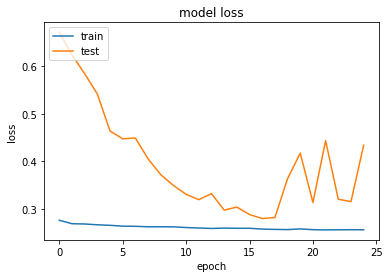

<Figure size 432x288 with 0 Axes>

In [ ]:
# grafico sommario della loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Si carica il modello salvato in precedenza

In [6]:
embeddingNet = tf.keras.models.load_model('/content/drive/MyDrive/MobileNetV3_lessEpoch')

Viene mostrata la struttura del modello (grafico)

In [ ]:
plot_model(embeddingNet, to_file='/content/drive/MyDrive/MobileNetV3_lessEpoch/model_mobileNetV3_lessEpoch.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

Viene mostrata la struttura del modello (tabella)

In [ ]:
embeddingNet.summary()

Model: "Embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                          

In [7]:
!cp  /content/drive/MyDrive/galleryFull.zip /content/
!unzip /content/galleryFull.zip -d /content/

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/gallery/51/14014/407_20220310_0.jpg  
   creating: /content/gallery/51/14015/
  inflating: /content/gallery/51/14015/47_20220222_0.jpg  
   creating: /content/gallery/51/14016/
  inflating: /content/gallery/51/14016/47_20220222_0.jpg  
  inflating: /content/gallery/51/14016/47_20220222_1.jpg  
   creating: /content/gallery/51/14017/
  inflating: /content/gallery/51/14017/28_20210614_0.jpg  
  inflating: /content/gallery/51/14017/56_20211110_1.jpg  
   creating: /content/gallery/51/14018/
  inflating: /content/gallery/51/14018/1799_20220314_3.jpg  
  inflating: /content/gallery/51/14018/1799_20220314_4.jpg  
  inflating: /content/gallery/51/14018/407_20220310_0.jpg  
  inflating: /content/gallery/51/14018/407_20220310_1.jpg  
   creating: /content/gallery/51/14019/
  inflating: /content/gallery/51/14019/1799_20220314_1.jpg  
  inflating: /content/gallery/51/14019/1799_20220314_2.jpg  
  inflating: /content/gallery/5

In [8]:
def display_9_images_from_dataset(dataset,etichette):
  index_dati=np.random.choice(len(completeDataset), 9)
  plt.figure(figsize=(10,10))
  subplot=331
  for i, (image,label) in enumerate(zip(dataset,etichette)):
      if not (i in index_dati):
        continue
      plt.subplot(subplot)
      plt.axis('off')
      plt.imshow(image.numpy())
      plt.title(label.numpy(), fontsize=16)
      subplot += 1
      if i==8:
        break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.2)
  plt.show()

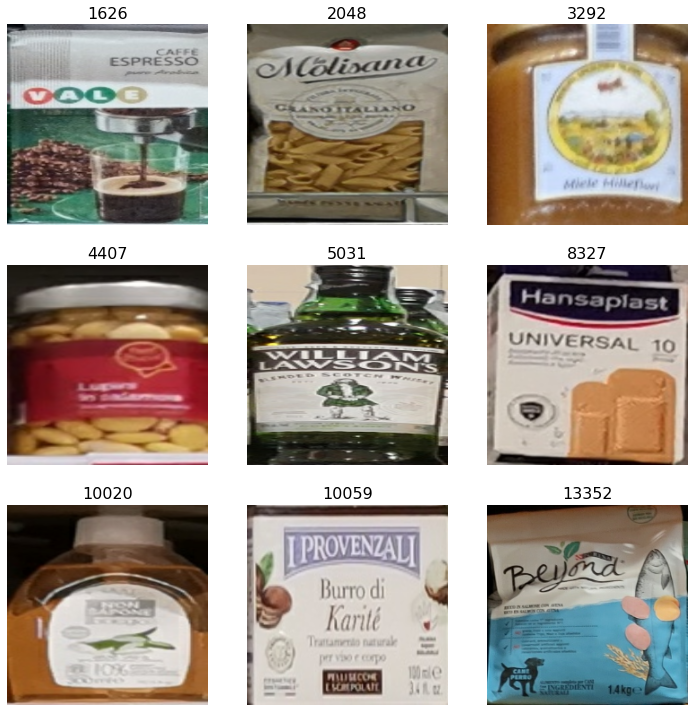

In [9]:
data_dir = "/content/gallery/"

data_dir = Path(data_dir)
list_ds = tf.data.Dataset.list_files(str(data_dir/'**/**/*.jpg'), shuffle=False)
label_list = []
for i in (list_ds):
    label_list = label_list + [int(i.numpy().decode().split('/')[-2])]

label_list = tf.data.Dataset.from_tensor_slices(label_list)
completeDataset = list_ds.map(read_image)

#Funzione per stampare 9 immagini dal dataset con tanto di label
display_9_images_from_dataset(completeDataset,label_list)

completeDataset = completeDataset.batch(batch_size, drop_remainder=False)
completeDataset = completeDataset.prefetch(8)

In [10]:
from tensorflow.keras.callbacks import Callback
import time
class PredictionCallback(Callback):
    start_time = time.time()
    #start_time_batch = time.time()
    
    def on_predict_begin(self, logs=None):
        self.start_time = time.time()
        print("Starting prediction ...")
    
    def on_predict_batch_begin(self, batch, logs=None):
        #start_time_batch = time.time()
        print(f"Prediction: Starting batch {batch}")
        
    def on_predict_batch_end(self, batch, logs=None):
        #end_time_batch = time.time()-start_time_batch
        print(f"Prediction: Finish batch {batch}")
    
    def on_predict_end(self, logs=None):
        end_time = time.time()-self.start_time
        print("Finished prediction"+f" -> Inference time: {end_time} seconds")

In [11]:
embeddingTotale = embeddingNet.predict(completeDataset, callbacks=[PredictionCallback()])

Starting prediction ...
Prediction: Starting batch 0
Prediction: Finish batch 0
Prediction: Starting batch 1
Prediction: Finish batch 1
Prediction: Starting batch 2
Prediction: Finish batch 2
Prediction: Starting batch 3
Prediction: Finish batch 3
Prediction: Starting batch 4
Prediction: Finish batch 4
Prediction: Starting batch 5
Prediction: Finish batch 5
Prediction: Starting batch 6
Prediction: Finish batch 6
Prediction: Starting batch 7
Prediction: Finish batch 7
Prediction: Starting batch 8
Prediction: Finish batch 8
Prediction: Starting batch 9
Prediction: Finish batch 9
Prediction: Starting batch 10
Prediction: Finish batch 10
Prediction: Starting batch 11
Prediction: Finish batch 11
Prediction: Starting batch 12
Prediction: Finish batch 12
Prediction: Starting batch 13
Prediction: Finish batch 13
Prediction: Starting batch 14
Prediction: Finish batch 14
Prediction: Starting batch 15
Prediction: Finish batch 15
Prediction: Starting batch 16
Prediction: Finish batch 16
Prediction

In [12]:
list_all_images_for_embedding = (list(list_ds.as_numpy_iterator()))

In [13]:
numFotoTotale = len(list_all_images_for_embedding)
print(numFotoTotale)

32205


In [14]:
EANTotale = []
imageTotale = []
cat_totale = []
for i in list_all_images_for_embedding:
  EANTotale = EANTotale + [i.decode('UTF-8').split('/')[-2]]
  cat_totale = cat_totale + [i.decode('UTF-8').split('/')[-3]]
  imageTotale = imageTotale + [i.decode('UTF-8').split('/')[-1].split('.')[0]]

In [15]:
EAN_imageTotale = []
for i in range(numFotoTotale):
  EAN_imageTotale = EAN_imageTotale + [EANTotale[i] + "_" + imageTotale[i] + "_" + cat_totale[i]]

In [16]:
dictTotale = {key: [] for key in EAN_imageTotale}
for k, v in zip(EAN_imageTotale, embeddingTotale):
    dictTotale[k].append(v)

In [17]:
!cp  /content/drive/MyDrive/testSetRidotto.zip /content/
!unzip /content/testSetRidotto.zip -d /content/

Archive:  /content/testSetRidotto.zip
   creating: /content/testSetRidotto/2/
   creating: /content/testSetRidotto/2/3522/
   creating: /content/testSetRidotto/2/3523/
   creating: /content/testSetRidotto/2/3524/
  inflating: /content/testSetRidotto/2/3524/41_20210614_3.jpg  
  inflating: /content/testSetRidotto/2/352441_20210614_3.jpg  
   creating: /content/testSetRidotto/2/3525/
  inflating: /content/testSetRidotto/2/3525/56_20211110_5.jpg  
  inflating: /content/testSetRidotto/2/3525/56_20211110_6.jpg  
  inflating: /content/testSetRidotto/2/352556_20211110_5.jpg  
  inflating: /content/testSetRidotto/2/352556_20211110_6.jpg  
   creating: /content/testSetRidotto/2/3526/
  inflating: /content/testSetRidotto/2/3526/56_20211110_4.jpg  
  inflating: /content/testSetRidotto/2/352656_20211110_4.jpg  
   creating: /content/testSetRidotto/2/3527/
  inflating: /content/testSetRidotto/2/3527/1_20210903_1.jpg  
  inflating: /content/testSetRidotto/2/35271_20210903_1.jpg  
   creating: /conte

In [18]:
data_dirTest = "/content/testSetRidotto/"
data_dirTest = Path(data_dirTest)
list_dsTest = tf.data.Dataset.list_files(str(data_dirTest/'**/**/*.jpg'), shuffle=False)
EANListTest = []
imageListTest = []
for i in (list_dsTest):
    EANListTest = EANListTest + [(i.numpy().decode().split('/')[-2])]
    imageListTest = imageListTest + [i.numpy().decode().split('/')[-1]]

datasetTest = list_dsTest.map(read_image)

datasetTest = datasetTest.batch(batch_size, drop_remainder=False)
datasetTest = datasetTest.prefetch(8)

In [19]:
embeddingTest = embeddingNet.predict(datasetTest, callbacks=[PredictionCallback()])

Starting prediction ...
Prediction: Starting batch 0
Prediction: Finish batch 0
Prediction: Starting batch 1
Prediction: Finish batch 1
Prediction: Starting batch 2
Prediction: Finish batch 2
Prediction: Starting batch 3
Prediction: Finish batch 3
Prediction: Starting batch 4
Prediction: Finish batch 4
Prediction: Starting batch 5
Prediction: Finish batch 5
Prediction: Starting batch 6
Prediction: Finish batch 6
Prediction: Starting batch 7
Prediction: Finish batch 7
Prediction: Starting batch 8
Prediction: Finish batch 8
Prediction: Starting batch 9
Prediction: Finish batch 9
Prediction: Starting batch 10
Prediction: Finish batch 10
Prediction: Starting batch 11
Prediction: Finish batch 11
Prediction: Starting batch 12
Prediction: Finish batch 12
Prediction: Starting batch 13
Prediction: Finish batch 13
Prediction: Starting batch 14
Prediction: Finish batch 14
Prediction: Starting batch 15
Prediction: Finish batch 15
Prediction: Starting batch 16
Prediction: Finish batch 16
Finished p

In [20]:
@jit(nopython=True)
def fast_cosine(u, v):
    m = u.shape[0]
    udotv = 0
    u_norm = 0
    v_norm = 0
    for i in range(m):
        if (np.isnan(u[i])) or (np.isnan(v[i])):
            continue

        udotv += u[i] * v[i]
        u_norm += u[i] * u[i]
        v_norm += v[i] * v[i]

    u_norm = np.sqrt(u_norm)
    v_norm = np.sqrt(v_norm)

    if (u_norm == 0) or (v_norm == 0):
        ratio = 1.0
    else:
        ratio = udotv / (u_norm * v_norm)
    return ratio

In [21]:
matching_EAN = []
matching_image = []
cosine_similarity_array = []
similarity_temp = -1
for i in embeddingTest:
	similarity_temp = -1
	for key, value in dictTotale.items():
		embedding_confronto = (((np.array(value, dtype = np.float32))))
		similarity = fast_cosine(np.array(i,dtype = np.float32), embedding_confronto[0])
		if similarity > similarity_temp:
			similarity_temp = similarity
			moreMatchingKey = key
	print(moreMatchingKey)
	matching_EAN = matching_EAN + [moreMatchingKey.split('_')[0]]
	matching_image = matching_image + [moreMatchingKey.split('_',1)[1] + '.jpg']
	cosine_similarity_array = cosine_similarity_array + [similarity_temp]

3524_41_20210614_1_2
3525_1_20210903_3_2
3525_1_20210903_3_2
3672_0_2
3587_1_20210903_1_2
3528_1_2
3529_41_20210614_3_2
3530_1_2
3531_1_2
3532_0_2
3528_1_2
3528_1_2
3535_41_20210614_4_2
3535_0_2
3536_1_2
3537_41_20210614_3_2
3538_41_20210614_2_2
3539_0_2
3540_1_20210903_2_2
3540_0_2
3541_41_20210614_0_2
3542_41_20210614_0_2
3543_41_20210614_2_2
3544_0_2
3545_41_20210614_2_2
6955_28_20210614_2_33
11307_28_20210614_1_43
3550_56_20211110_0_2
3551_2_2
3552_0_2
3555_0_2
3558_41_20210614_0_2
3560_41_20210614_1_2
3561_0_2
10921_28_20210614_0_43
3566_41_20210614_1_2
3567_0_2
3568_0_2
3570_0_2
1937_1_20210903_0_14
3572_41_20210614_2_2
3573_41_20210614_2_2
3575_56_20211110_3_2
3576_56_20211110_1_2
3577_41_20210614_2_2
3578_41_20210614_1_2
3579_56_20211110_1_2
3580_56_20211110_2_2
3582_1_20210903_0_2
3591_10_2
3585_1_20210903_1_2
3586_41_20210614_0_2
3587_1_20210903_1_2
3588_1_20210903_1_2
3589_56_20211110_0_2
3590_56_20211110_0_2
3591_12_2
3591_15_2
3591_16_2
3591_18_2
3593_1_20210903_2_2
3594_4

In [22]:
def create(lst):
    l = []
    for a, b, c, d in lst:
        l.append((float(a), b, c, d))
    return l

similarity_temp = []
EAN_temp = []
topN = []
topNTotale = []
count = 0
for i in embeddingTest:
	similarity_temp = []
	EAN_temp = []
	imagePath = []
	cat = []
	keyAttuale = list(EANListTest)[count]
	for key, value in dictTotale.items():
		embedding_confronto = (((np.array(value, dtype = np.float32))))
		similarity = fast_cosine(np.array(i), embedding_confronto[0])
		catTemp = key.split('_')[-1]
		PathTemp = '_'.join(key.split('_')[1:-1]) + '.jpg'
		if similarity > 0.2:
				similarity_temp = similarity_temp + [similarity]
				EAN_temp = EAN_temp + [key.split('_')[0]]
				imagePath = imagePath + [PathTemp]
				cat = cat + [catTemp]
	z = np.array(create(zip(similarity_temp,EAN_temp,imagePath,cat)))
	topN = z[np.argsort(z[:, 0].astype('float'))]
	topN = topN[-10:]
	topN = np.flip(topN, axis = 0)
	topN = list(topN)
	topN.append(keyAttuale)
	topN.append(imageListTest[count])
	count = count + 1
	print(count)
	topNTotale = topNTotale + [topN]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [23]:
totaleCountTop5 = len(topNTotale)
countTop5 = 0
for i in range(totaleCountTop5):
  if (topNTotale[i][0][1]==topNTotale[i][10] or topNTotale[i][1][1]==topNTotale[i][10] or topNTotale[i][2][1]==topNTotale[i][10] or topNTotale[i][3][1]==topNTotale[i][10] or topNTotale[i][4][1]==topNTotale[i][10]):
    countTop5 = countTop5 + 1
print(countTop5/totaleCountTop5)

0.9346781940441883


In [24]:
top10Totale = topNTotale
totaleCountTop10 = len(topNTotale)
countTop10 = 0
for i in range(totaleCountTop10):
  if (topNTotale[i][0][1]==topNTotale[i][10] or topNTotale[i][1][1]==topNTotale[i][10] or topNTotale[i][2][1]==topNTotale[i][10] or topNTotale[i][3][1]==topNTotale[i][10] or topNTotale[i][4][1]==topNTotale[i][10] or topNTotale[i][5][1]==topNTotale[i][10] or topNTotale[i][6][1]==topNTotale[i][10] or topNTotale[i][7][1]==topNTotale[i][10] or topNTotale[i][8][1]==topNTotale[i][10] or topNTotale[i][9][1]==topNTotale[i][10]):
    countTop10 = countTop10 + 1
print(countTop10/totaleCountTop10)

0.9538904899135446


In [25]:
resultCosineTest = pd.DataFrame({'EANTest': EANListTest, 'nameImageTest': imageListTest, 'matchingEAN': matching_EAN, 'nameImageMatch': matching_image, 'cosineSimilarity': cosine_similarity_array})

In [26]:
comparison_column = np.where(resultCosineTest["EANTest"] == resultCosineTest["matchingEAN"], True, False)
resultCosineTest["Same"] = comparison_column
true_count = (resultCosineTest.Same).sum()
accuracy = true_count / len(resultCosineTest)

In [27]:
print(accuracy)

0.8626320845341018
